Во [вложении]() выгрузка данных из яндекс-формы.

Задача, провести исследование.

Ответ + код лучше в колабе или * ipynb , или дашборды
 

Пример, как мы это сейчас визуализировали один из вопросов и отображение ответов:

![](images/image002.jpg)<br>
![](images/image003.jpg)<br>

In [44]:
# from openpyxl import Workbook, load_workbook
# from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [45]:

import geopandas as gpd
import plotly.graph_objects as go
from shapely.geometry import Point

# Знакомство с данными

In [3]:
# путь к файлу
file_path='files/2025.06.23.15.00test.xlsx'
# записываем в датафрейм файл
data= pd.read_excel(file_path)
# смотрим на случайную строку
data.sample(n=1, random_state=42).T

,30
ID,NaN
Время создания,NaN
Наименование организации:,"ООО ""Альфа Телеком Стандарт"""
Регион,Республика Татарстан (Татарстан)
Город,Набережные Челны
...,...
Какие геоинформационные операции могут быть наиболее востребованы и были бы полезны в вашей деятельности: / Создание анимаций. Визуализация динамики процессов (пример 1: распространение пожара; пример 2: рост города за 50 лет).,NaN
Какие геоинформационные операции могут быть наиболее востребованы и были бы полезны в вашей деятельности: / Иное,NaN
"Иные геоинформационные операции, которые востребованы в вашей деятельности",NaN
"Укажите идеи для геоинформационных сервисов и решений (включающие карты, пространственные данные, геоаналитику) под задачи, которые могли быть востребованы организацией:",NaN


Первично можно сказать, что даптасет содержит информацию с опросника организаций с указанием региона и города. Полей много и смотреть их в виде таблицы или графика в исходном виде будет неудобно. 

In [4]:
# Выводим информацию о размере датафрейма
print(f"Датасет содержит: {len(data)} строк, \
{data.shape[1]} столбцов")


Датасет содержит: 80 строк, 179 столбцов


In [5]:
#столбцов с определенным типом данных в датафрейме
data.dtypes.value_counts()

object     164
float64     15
Name: count, dtype: int64

Датасет содержит два типа данных: строки (object) и числовой (float64) Это означает, что данные содержат строки, а также либо число с плавающей точкой либо пропуски. При первом взгляде для полей `ID`тип данных обычно целочисленный/строковый, 	`Время создания` - datetime/time.

Посмотрим на пропуски.

In [6]:
print(f"Всего датасет содержит {data.isnull().values.sum()} пропусков.\n\
=========================================")
print('Медианное количество пропусков в каждом из',
data.shape[1], 'столбцов:', 
int(data.isna().sum().median()), 'или ', 
round((data.isna().sum().median() / len(data)) * 100), '% \n\
=========================================')
print('Cтолбцы без пропусков:')
# процент нулевых значений
cnt_full_col = 0
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    if pct_missing == 0:
        cnt_full_col +=1
        print("{}. {}".format(cnt_full_col, col))

Всего датасет содержит 9274 пропусков.
Медианное количество пропусков в каждом из 179 столбцов: 64 или  80 % 
Cтолбцы без пропусков:
1. Наименование организации:
2. Регион
3. Город
4. Знаете ли вы о запрете использования зарубежных геоинформационных технологий органами государственной власти с 1 января 2026 года, согласно Федеральному закону от 30.12.2015 № 431-ФЗ ‎«О геодезии, картографии и пространственных данных и о внесении изменений ‎в отдельные законодательные акты Российской Федерации»
5. Знали ли вы о существовании такого продукта прежде?
6. Готовы ли Вы ответить на несколько вопросов в рамках онлайн - интервью?


In [7]:
print('Cтолбцы со 100% пропусками:\n\
=========================================')
cnt_null_col = 0
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    if pct_missing == 1:
        cnt_null_col += 1
        print('{}. {}'.format(cnt_null_col, col))

Cтолбцы со 100% пропусками:
1. ID
2. Время создания
3. Отрасль/сфера деятельности: / Торговля и общественное питание
4. Отрасль/сфера деятельности: / Материально-техническое снабжение и сбыт
5. Отрасль/сфера деятельности: / Заготовки
6. Отрасль/сфера деятельности: / Общая коммерческая деятельность по обеспечению функционирования рынка
7. Отрасль/сфера деятельности: / Непроизводственные виды бытового обслуживания населения
8. Отрасль/сфера деятельности: / Финансы, кредит, страхование, пенсионное обеспечение
9. Отрасль/сфера деятельности: / Общественные объединения
10. Вид организации: / федеральный орган исполнительной власти (или его подразделение)
11. Вид организации: / орган исполнительной власти субъекта Российской Федерации (или его подразделение)
12. Респондент (сотрудник организации, заполнивший форму), ФИО:
13. Должность респондента  (сотрудника организации, заполнившего форму):
14. Контактный электронный адрес организации:
15. Контактный телефон организации:


Данные об `ID`  и  `Время создания ` отсутствуют, с большой долей вероятности это из-за предоставления для публичного просмотра. Такие же причины могут быть и у других столбцов со 100% пропусками.

На пропусках не будем заострять фокус по причине большого количества полей с ними. Просто  отмечаем этот факт, как требующий дополнительного исследования причин пропусков. Дополнительно отметим, что эти пропуски могут быть как естественными/нормальными, так и сигналом к поиску их причины.

Проверить на наличие явных дубликатов без ключевого поля `ID` для компаний нельзя. Посмотрим есть ли совпадения по трем полям, в которых нет пропусков:
 - `Наименование организации: `
 - `Регион `  
 - `Город  ` 

In [9]:
#посчитаем  дубликаты по конкретным полям
print(f"Количество дубликатов по полям \
'Наименование организации:', 'Регион', 'Город': \
{data[['Наименование организации:', 'Регион', 'Город']].
duplicated().sum()} шт.")

Количество дубликатов по полям 'Наименование организации:', 'Регион', 'Город': 0 шт.


In [50]:
# list(data.columns)

Посчитаем уникальные значения в столбцах некоторых полей и посмотрим на уникальные значения одного полей.


In [11]:
col_list = ['Наименование организации:', 
            'Регион', 
            'Город']
# Проверяем количество уникальные значения в столбцах всего датафрейма
print('Уникальных значений в столбцах датафрейма:')
for column in data[col_list]:
    print(f'{data[column].nunique()} в столбце: "{column}"')


Уникальных значений в столбцах датафрейма:
79 в столбце: "Наименование организации:"
29 в столбце: "Регион"
57 в столбце: "Город"


In [12]:
data['Вид деятельности организации'].unique()

array([nan, 'Проектирование и изыскания', 'Частная организация',
       'пенсионер с огромным опытом работ и знаниями за пределами действующих регламентов в технологиях завтрашнего дня.С опытом работ и преподавания геоинформационных дисциплин вв 12ти странах мира. с долгами по неоплате заказчиков - победителей госконтрактов.',
       'Федеральное государственное бюджетное учреждение науки',
       'Коммерческая организация', 'Коммерческая частная компания',
       'Инженерные изыскания',
       'Общество с ограниченной ответственностью ',
       'Разработка компьютерного программного обеспечения',
       'Проектирование и осуществление функций технического заказчика',
       'Индивидуальный Предприниматель',
       'Общество с ограниченной ответственностью',
       'Индивидуальный предприниматель',
       'Электромонтажные работы и обслуживание систем противопожарной безопасности',
       'Общество с ограниченной ответственностью.', 'Стьроительство',
       'частная собственность',
   

Данные по полю `Вид деятельности организации` скорее всего внесены без выбора (введены вручную), что требует дополнительной обработки, группировки с предварительным пониманием того, что подразумевается под "вид деятельности организации". Даже при незначительных (80 организаций) размерах датасета данные о разном (форма собственности, юридическое оформление (ИП, ООО), оквэд в кодировке и расшифровке. С увеличением данных увеличится и виды трактовок поля респондентом, ошибки. Из рекомендаций - зафиксировать виды деятельности и дать пользователю возможность выбирать, а не печатать данные.

Стоит также проанализировать и другие поля на уровне формы для заполнения и во всех случаях, когда есть возможность указать список значений - сделать именно так.

Посмотрим на целевые поля из референса, а именно нас интересуют 
 - количество упоминаний по регионам в абсолютном и относительном значении
 - Подсчет значений  в Поле "Знали ли вы о существовании такого продукта прежде?" в абсолютном и относительном значении
 - Подсчет значений в Поле "Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?"


In [13]:
# в список фиксируем интересующие поля 
col_list = ['Знали ли вы о существовании такого продукта прежде?',
            'Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?'
           ]
# смотрим какие уникальные значения в интересующих полях               
for i, col in enumerate(col_list):
    print('В поле: "{}"\n{} уникальных значения: {}\
\n'.format(col_list[i],
         data[col].nunique(),
         list(data[col].unique())
        )    
         )

В поле: "Знали ли вы о существовании такого продукта прежде?"
2 уникальных значения: ['Да', 'Нет']

В поле: "Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?"
4 уникальных значения: ['нет, потребность отсутствует', 'да (уже используем)', 'да (пока не используется, хотели бы использовать)', 'требуется более подробная информация о продукте', nan]



Значения в полях не вызывают вопросов. 
# Цифровой ортофотоплан

## Знали ли вы о существовании такого продукта прежде?" 
Посчитаем количество ответов и их долю В поле: "Знали ли вы о существовании такого продукта прежде?"

In [14]:
# для нужного поля по индексу из col_list посчитаем  нужное
print(col_list[0],
'\nОбщее количество ответов:', data[col_list[0]].count(),     )

answer1 = (data[col_list[0]]
           .value_counts(dropna=False)
           .reset_index())
# переименуем поля
answer1.columns = ['Ответ', 'Количество']
answer1['Процент, %'] = round(
    answer1['Количество'] / 
    answer1['Количество'].sum() * 100
                         , 2)
# посмотрим что получилос
answer1

Знали ли вы о существовании такого продукта прежде? 
Общее количество ответов: 80


,Ответ,Количество,"Процент, %"
0,Да,48,60.0
1,Нет,32,40.0


Добавим визуализацию пайчарт для полученных данных

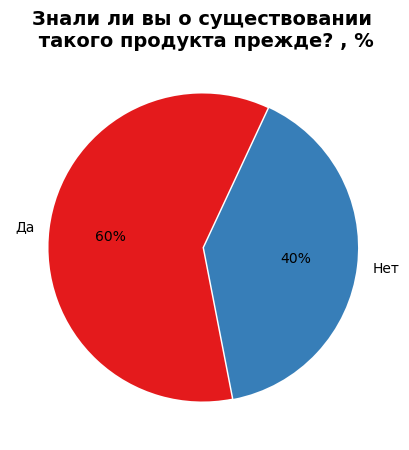

In [15]:
# зададим размеры фигуры
plt.figure(figsize=(5,5))
# определим расстояние междучастями пайчарта
explode = [0, 0.01] 
# определим цветовую палитру 
palette_color = sns.color_palette('Set1') 
  
# задаем параметры для пайчарта
plt.pie(answer1['Количество'], 
        labels=answer1['Ответ'], 
        colors=palette_color, 
        explode=explode, 
        startangle=65, # поворот пайчарта
        autopct='%.0f%%') 
 #подписываем график
plt.title('Знали ли вы о существовании\n такого продукта прежде? , %',
         fontsize=14, fontweight="bold")

#выводим график
plt.show()  

60% респондентов утверждают, что знали о продукте прежде.

## Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?


In [16]:
# для нужного поля по индексу из col_list посчитаем  нужное
print(col_list[1],
'\nОбщее количество ответов:', data[col_list[1]].count())

answer2 = (data[col_list[1]]
           .value_counts(dropna=True)
           .reset_index())
# переименуем поля
answer2.columns = ['Значение', 'Количество']
answer2['Процент, %'] = round(
    answer2['Количество'] / 
    answer2['Количество'].sum() * 100
                         , 2)
# посмотрим что получилос
answer2

Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций? 
Общее количество ответов: 79


,Значение,Количество,"Процент, %"
0,"нет, потребность отсутствует",30,37.97
1,"да (пока не используется, хотели бы использовать)",26,32.91
2,да (уже используем),19,24.05
3,требуется более подробная информация о продукте,4,5.06


Добавим визуализациидля получившейся информации: диаграмму и пайчарт.

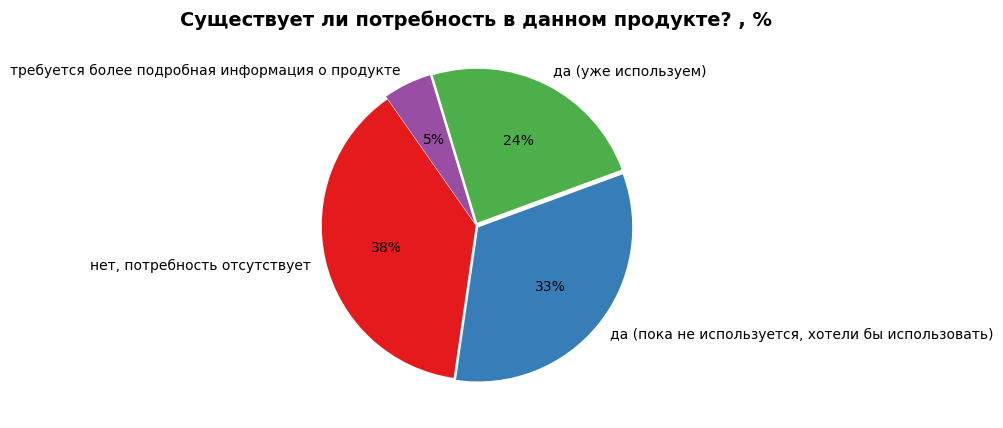

In [17]:
# зададим размеры фигуры
plt.figure(figsize=(5,5))
# определим расстояние междучастями пайчарта
explode = [0, 0.02, 0.02, 0.02] 
# определим цветовую палитру 
palette_color = sns.color_palette('Set1') 
  
# задаем параметры для пайчарта
plt.pie(answer2['Количество'], 
        labels=answer2['Значение'], 
        colors=palette_color, 
        explode=explode, 
        startangle=125, # поворот пайчарта
        autopct='%.0f%%') 
 #подписываем график
plt.title('Существует ли потребность в данном продукте? , %',
         fontsize=14, fontweight="bold")

#выводим график
plt.show()  

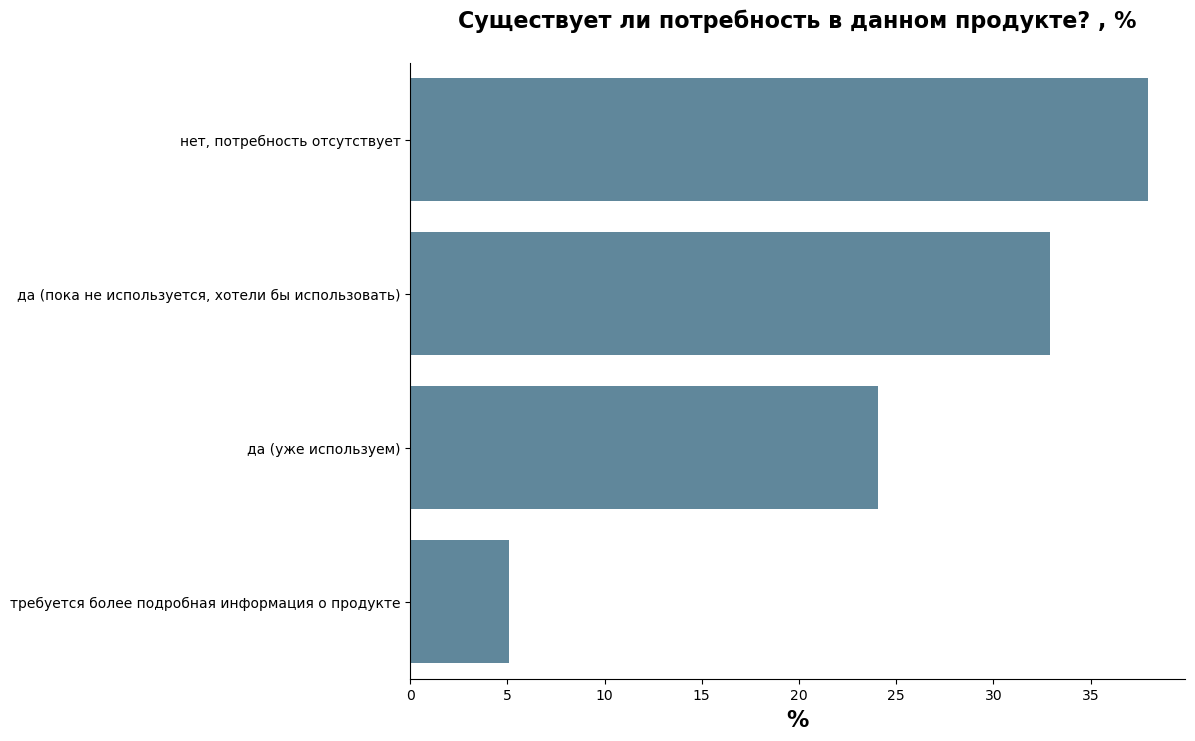

In [18]:
#строим график
plt.figure(figsize=(10,8))

sns.barplot(data=answer2,
            y='Значение', 
            x='Процент, %',
            color='#447D9B',       # цвет столбцов
            legend='auto',
            alpha=0.9)
           
#подписываем график
plt.title('Существует ли потребность в данном продукте? , %\n',
         fontsize=16, fontweight="bold")

#добавляем подписи по осям Х,убираем по оси У
plt.ylabel('')
plt.xlabel('%',fontsize = 16, fontweight ='bold')
           
#уберем границы в графике-функция Seaborn despine удаляет правую и верхнюю границы из визуализации данных
sns.despine()
#выводим график
plt.show()

In [19]:
#!pip install geopandas

# Подготовка карты РФ
На основе кода по геоданным из  [источника](https://github.com/hairymax/offline_russia_plotly/blob/main/geodata_preparation.ipynb) c дополнением данных по [ДНР](https://github.com/EugeneBorshch/ukraine_geojson/blob/master/UA_14_Donetska.geojson)


In [20]:
# 
import geopandas as gpd
# убрать ошибку: Set SHAPE_RESTORE_SHX config option to YES to restore or create it. 
from pyogrio import set_gdal_config_options
set_gdal_config_options({ 'SHAPE_RESTORE_SHX': 'YES', })

from tqdm import tqdm
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [21]:
gdf_raw = gpd.read_file("files/russia_regions.geojson")
gdf_raw.info()            
gdf_raw.sample(n=4, random_state=42)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   region            85 non-null     object  
 1   federal_district  85 non-null     object  
 2   population        85 non-null     int32   
 3   geometry          85 non-null     geometry
dtypes: geometry(1), int32(1), object(2)
memory usage: 2.5+ KB


,region,federal_district,population,geometry
78,Мурманская область,Северо-Западный,658698,"MULTIPOLYGON (((37.70574 68.6977, 37.71026 68...."
0,Пензенская область,Приволжский,1246609,"MULTIPOLYGON (((42.08174 53.748, 42.08525 53.7..."
68,Красноярский край,Сибирский,2845545,"MULTIPOLYGON (((81.06915 72.2315, 81.05911 72...."
22,Санкт-Петербург,Северо-Западный,5600044,"MULTIPOLYGON (((30.06502 59.66822, 30.0734 59...."


Сравним все ли данные по регионам соответствуют загружаемым геоданным.

Для начала создадим датафрейм на основе исходного с несколькими нужными полями, в том числе с полем  `Регион`

In [22]:
# делаем копию основного датасета 
data_reg = data.copy(deep=True)
# оставляем только нужные поля
data_reg = data_reg[['Наименование организации:', 
                   'Регион', 
                   'Город', 
                   'Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?'
                  ]]
# смотрим на несколько сл.строк
data_reg.sample(n=4, random_state=45)

,Наименование организации:,Регион,Город,Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?
55,"ООО ""Геосити""",Новосибирская область,Новосибирск,да (уже используем)
25,"ООО ""Комплекс-Инжиниринг""",Пензенская область,Пенза,"нет, потребность отсутствует"
10,ФГБНУ РАНИМИ,Донецкая Народная Республика,Донецк,"да (пока не используется, хотели бы использовать)"
19,Кубанский государственный университет,Краснодарский край,Краснодар,да (уже используем)


Напишем функцию `set_compare`, которая поможет сравнить уникальные значения в сериях данных из наших датафреймов с помощью множеств.

Функция set_compare для сравнения множеств

In [23]:
def set_compare(series_a, series_b):
    '''
    series_a - данные по регионам в исходном датасете
    series_b - данные по регионам из геоданных загруженных из сети
    '''
    set_a = set(series_a)
    set_b = set(series_b)

    print("Уникальных значений в исходном датафрейме: \
{}.".format(len(set_a)))
    print("Уникальных общих значений {}.\
".format(len(set_a & set_b)))   
    print("Нет совпадений по регионам:\n", set_a.difference(set_b))

Применим функцию set_compare к множествам из столбца `region` датафрейма `gdf_raw` и `Регион` датафрейма `data_reg`

In [24]:
# сравниваем
set_compare(    
    data_reg['Регион'], 
    gdf_raw['region'])

Уникальных значений в исходном датафрейме: 29.
Уникальных общих значений 26.
Нет совпадений по регионам:
 {'Республика Татарстан (Татарстан)', 'Донецкая Народная Республика', 'Кемеровская область - Кузбасс'}


Посмотрим на уникальные значения из столбца region датафрейма `gdf_raw` 

In [25]:
sorted(gdf_raw.region.unique())

['Алтайский край',
 'Амурская область',
 'Архангельская область',
 'Астраханская область',
 'Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Волгоградская область',
 'Вологодская область',
 'Воронежская область',
 'Еврейская автономная область',
 'Забайкальский край',
 'Ивановская область',
 'Иркутская область',
 'Кабардино-Балкарская Республика',
 'Калининградская область',
 'Калужская область',
 'Камчатский край',
 'Карачаево-Черкесская Республика',
 'Кемеровская область',
 'Кировская область',
 'Костромская область',
 'Краснодарский край',
 'Красноярский край',
 'Курганская область',
 'Курская область',
 'Ленинградская область',
 'Липецкая область',
 'Магаданская область',
 'Москва',
 'Московская область',
 'Мурманская область',
 'Ненецкий автономный округ',
 'Нижегородская область',
 'Новгородская область',
 'Новосибирская область',
 'Омская область',
 'Оренбургская область',
 'Орловская область',
 'Пензенская область',
 'Пермский край',
 'Приморский край',
 

В результате сопоставления видим, что два названия можно заменить, а данные по `Донецкая Народная Республика` добавить:
 - 'Донецкая Народная Республика' - данных нет
 - 'Кемеровская область - Кузбасс' - 'Кемеровская область'
 - 'Республика Татарстан (Татарстан)' - 'Республика Татарстан'

Внесем изменения в файл с геоданными - исправим наименование регионов и добавим ДНР. Загрузим обновленные данные из [файла](files/russia_regions_new.geojson) и подготовим карту.

In [26]:
gdf = gpd.read_file("files/russia_regions_new.geojson")
gdf.info()            
gdf.sample(n=4, random_state=1)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   region            86 non-null     object  
 1   federal_district  86 non-null     object  
 2   population        86 non-null     int32   
 3   geometry          86 non-null     geometry
dtypes: geometry(1), int32(1), object(2)
memory usage: 2.5+ KB


,region,federal_district,population,geometry
38,Ульяновская область,Приволжский,1181006,"MULTIPOLYGON (((45.79665 53.98576, 45.79742 53..."
44,Оренбургская область,Приволжский,1841377,"MULTIPOLYGON (((50.76848 51.77351, 50.77278 51..."
27,Севастополь,Крымский,558273,"MULTIPOLYGON (((33.83026 44.55701, 33.83024 44..."
40,Самарская область,Приволжский,3142683,"MULTIPOLYGON (((47.9368 53.36203, 47.9394 53.3..."


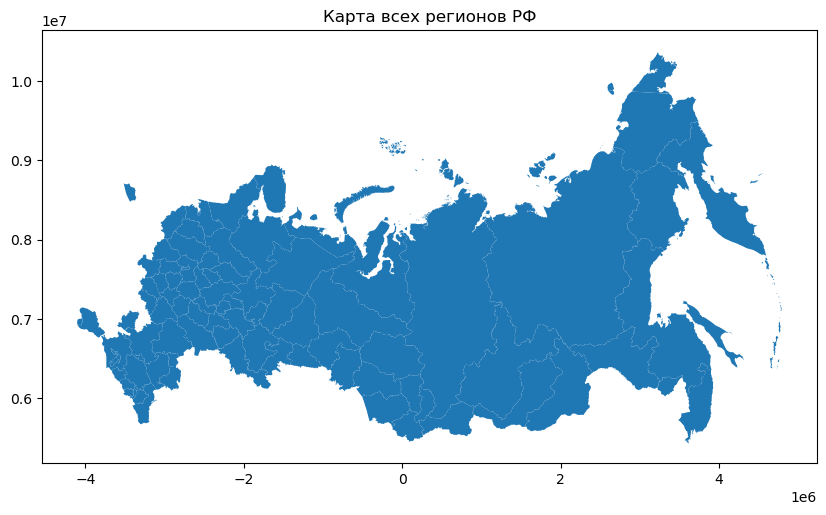

In [27]:
crs = 'EPSG:32646' 
gdf = gdf.to_crs(crs)
gdf.plot(figsize=(10,6))

plt.title('Карта 86 регионов РФ'), plt.show();

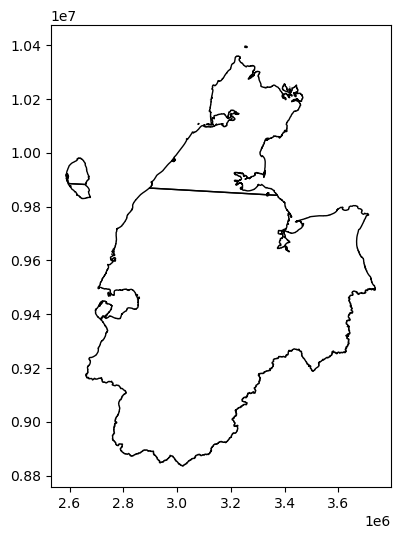

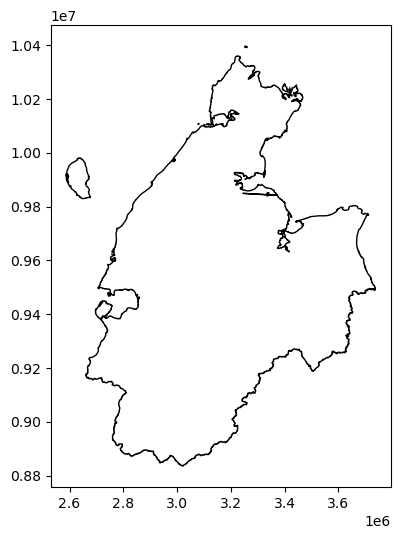

In [28]:
CHUK = 'Чукотский автономный округ'

gdf.loc[gdf.region == CHUK].plot(figsize=(6,6), facecolor="none")
plt.show()

# Объединение разбитых полигонов Чукотки
new_chuk = []
chuk_geoms = gdf.loc[gdf.region == CHUK, 'geometry'].values[0].geoms

# приклеим друг к другу полигоны находящиеся на расстоянии менее 100 единиц
for i, g in enumerate(chuk_geoms):
    new_g = g
    for j in range(len(chuk_geoms)):
        new_g = snap(new_g, chuk_geoms[j], 100)
    new_chuk.append(new_g)
new_chuk = unary_union(MultiPolygon(new_chuk))
gdf.loc[gdf.region == CHUK, 'geometry'] = new_chuk

gdf.loc[gdf.region == CHUK].plot(figsize=(6,6), facecolor="none")
plt.show();

In [29]:
# модуль tqdm для отслеживания прогресса выполнения.
from tqdm import tqdm
# функция упрощения геометрии всех регионов
def prepare_regions(gdf, area_thr=100e6, simplify_tol=500):
    """Подготовка регионов к построению
    
    - Упрощение геометрии с допуском simplify_tol
    - Удаление полигонов с пощадью менее area_thr
    """
    gdf_ = gdf.copy()
    
    # Вспомогательный столбец для упорядочивания регионов по площади
    gdf_['area'] = gdf_.geometry.apply(lambda x: x.area)

    # Удаляем маленькие полигоны
    tqdm.pandas(desc='Удаление мелких полигонов')
    gdf_.geometry = gdf_.geometry.progress_apply(lambda geometry: 
        MultiPolygon([p for p in geometry.geoms if p.area > area_thr]) 
            if type(geometry) == MultiPolygon else geometry
    )
    
    # Упрощение геометрии
    gdf_.geometry = gdf_.geometry.simplify(simplify_tol)
    
    geoms = gdf_.geometry.values
    pbar = tqdm(enumerate(geoms), total=len(geoms))
    pbar.set_description_str('Объединение границ после упрощения')
    # проходим по всем граничащим полигонам и объединяем границы
    for i, g in pbar:
        g1 = g
        for g2 in geoms:
            if g1.distance(g2) < 100:
                g1 = snap(g1, g2, 800)
        geoms[i] = g1
    gdf_.geometry = geoms
    
    # сортировка по площади
    gdf_ = gdf_.sort_values(by='area', ascending=False).reset_index(drop=True) 
    
    return gdf_.drop(columns=['area'])

Необходимо преобразовать полигоны и мультиполигоны в шэйпы, которые способна считывать для построения Plotly. 

Графические объекты поддерживают рисование GeoJSON объектов только на упомянутых слоях типа go.layout.Geo. 

Поэтому остаётся только использовать класс go.Scatter, а значит, необходимо перевести геометрии в формат отдельных массивов координат x и y. Для этого реализована функция‑преобразование `geom2shape`.

In [30]:
# функция‑преобразование
def geom2shape(g):
    """Преобразование полигонов и мультиполигонов в plotly-readable шэйпы    
    
    Получает на вход Polygon или MultiPolygon из geopandas, 
    возвращает pd.Series с координатами x и y
    """
    # Если мультиполигон, то преобразуем каждый полигон отдельно, разделяя их None'ами
    if type(g) == MultiPolygon:
        x, y = np.array([[], []])
        for poly in g.geoms:
            x_, y_ = poly.exterior.coords.xy
            x, y = (np.append(x, x_), np.append(y, y_))
            x, y = (np.append(x, None), np.append(y, None))
        x, y = x[:-1], y[:-1]
    # Если полигон, то просто извлекаем координаты
    elif type(g) == Polygon:      
        x, y = np.array(g.exterior.coords.xy)
    # Если что-то другое, то возвращаем пустые массивы
    else:
        x, y = np.array([[], []])
    return pd.Series([x,y])

Если преобразуется мультиполигональный объект, то последовательность координат каждого полигона отделяется от последующего с помощью `None`. Так `Plotly` в режиме заливки будет закрашивать каждый замкнутый контур отдельно, но при этом на карте это будет считаться единым объектом.

In [31]:
# Упрощение геометрии   
regions = prepare_regions(gdf)

# Преобразование полигонов в шейпы   
regions[['x','y']] = regions.geometry.progress_apply(geom2shape)
# Запись на диск   
regions.to_parquet('files/russia_regions.parquet')
regions.head()

Удаление мелких полигонов: 100%|██████████| 86/86 [00:00<00:00, 728.84it/s]


,region,federal_district,population,geometry,x,y
0,Республика Саха (Якутия),Дальневосточный,997565,"MULTIPOLYGON (((1934420.117 8487439.714, 19405...","[1934420.1169244426, 1940534.4765284657, 19409...","[8487439.714132698, 8486501.334447775, 8485674..."
1,Красноярский край,Сибирский,2845545,"MULTIPOLYGON (((32056.799 8132134.757, 35462.3...","[32056.79935566982, 35462.3772034038, 36374.32...","[8132134.756812158, 8129810.54575796, 8125543...."
2,Хабаровский край,Дальневосточный,1284090,"MULTIPOLYGON (((3260155.621 7013112.507, 32626...","[3260155.6214775788, 3262629.3414506745, 32634...","[7013112.506960788, 7011116.731883681, 7011621..."
3,Чукотский автономный округ,Дальневосточный,47840,"MULTIPOLYGON (((2741726.517 9584552.374, 27422...","[2741726.5174139286, 2742235.2573461686, 27438...","[9584552.374254184, 9584978.506388908, 9583772..."
4,Иркутская область,Сибирский,2344360,"POLYGON ((672251.138 6019892.875, 673691.301 6...","[672251.1376689398, 673691.300765981, 673446.4...","[6019892.874562745, 6017792.204244802, 6015136..."


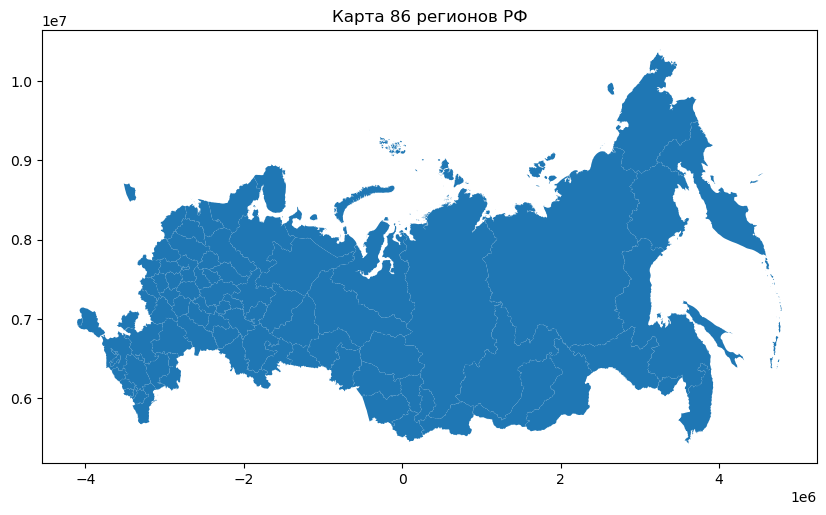

In [32]:
# система отсчёта в единицах широты и долготы EPSG:32646 (стандарт EPSG:4326.)
crs = 'EPSG:32646' # Pulkovo 95 CRS
gdf = gdf.to_crs(crs)
gdf.plot(figsize=(10,6))

plt.title('Карта 86 регионов РФ'), plt.show();

## Объединение данных

Теперь соединим геоданные с данными датафрейма 

In [33]:
merge_df = pd.merge(data_reg,
                    regions, 
                    how='left', 
                    on=None, 
                    left_on='Регион', 
                    right_on='region', 
                    left_index=False, 
                    right_index=False, 
                    sort=False, 
                    suffixes=('_x', '_y'))

In [34]:
# merge_df.query('Регион == "Донецкая Народная Республика"').T

In [51]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 10 columns):
 #   Column                                                                                                                          Non-Null Count  Dtype   
---  ------                                                                                                                          --------------  -----   
 0   Наименование организации:                                                                                                       80 non-null     object  
 1   Регион                                                                                                                          80 non-null     object  
 2   Город                                                                                                                           80 non-null     object  
 3   Существует ли потребность в данном продукте для решения специализированных задач подразделения и подве

Для дашборда выгрузим данные с координатами и нужным вопросом о потребности продукта.


In [52]:
# функция для сохранения датафрейма
def csv_download_link(df, csv_file_name, delete_prompt=True):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink
    display(FileLink(csv_file_name))
    if delete_prompt:
        a = input('Press enter to delete the file after you have downloaded it.')
        import os
        os.remove(csv_file_name)

In [53]:
csv_download_link(merge_df, 'merge_df.csv')

C:\Users\brnat\github_repos\Done_tasks\BI\merge_df.csv

Press enter to delete the file after you have downloaded it. 


# Карта распространенности регионов

In [36]:
# Выполним группировку и агрегацию 
pivot_data = (pd.pivot_table(merge_df,
                             index="Регион",
                             values="region",
                             aggfunc="count")
              .rename(columns={'region': 'Количество'})
              .sort_values(by='Количество', ascending=False)
               )
# добавляем столбец
pivot_data['Процент, %'] = (round(pivot_data['Количество'] / 
                                  pivot_data['Количество'].sum() * 100, 2)
                           )
# сбрасываем индексы
pivot_data.reset_index(inplace=True) 
# добавляем столбец из геоданных(по референсу)
pivot_data = pd.merge(pivot_data,
                    regions[['region', 'geometry', 'x', 'y']], 
                    how='left', 
                    left_on='Регион', 
                    right_on='region', 
                    left_index=False, 
                    right_index=False, 
                    sort=False).rename(columns={'region': 'GeoJSON_Region'})                

In [37]:
print('Регион\nОбщее количество заполненных ответов {}\
'.format(pivot_data['Количество'].sum()))
# выводим данные по сводной таблице
pivot_data[['Регион', 'Количество', 'Процент, %', 'GeoJSON_Region']]

Регион
Общее количество заполненных ответов 80


,Регион,Количество,"Процент, %",GeoJSON_Region
0,Пензенская область,12,15.00,Пензенская область
1,Москва,8,10.00,Москва
2,Краснодарский край,6,7.50,Краснодарский край
3,Московская область,5,6.25,Московская область
4,Калужская область,5,6.25,Калужская область
5,Кемеровская область - Кузбасс,5,6.25,Кемеровская область - Кузбасс
6,Липецкая область,4,5.00,Липецкая область
7,Пермский край,4,5.00,Пермский край
8,Республика Татарстан (Татарстан),3,3.75,Республика Татарстан (Татарстан)
9,Новосибирская область,3,3.75,Новосибирская область


## Слой-подложка карты
Всё (russia_regions.parquet') готово , чтобы создать слой‑подложку для карты. 

Построение буду проводить с помощью собственного класса mapFigure, который наследуется от класса фигуры Plotly — go.Figure. 

Для этого импортирую подмодуль plotly.graph_objects, который содержит основные классы для построения фигур. 
код модуля [map_figure.py](map_figure.py). Помимо класса mapFigure в нём реализована функция convert_crs для преобразования координат в двух массивах x_arr, y_arr из одной системы отсчёта в другую. Она пригодится для подготовки данных к отображению на карте. 

У `go.Figure` разработчики отключили возможность добавления новых атрибутов и методов. Но здесь можно обойтись переопределением метода инициализации, а дальше работать с картой, как с обычным `go.Figure`.

In [46]:
'''Класс для слоя подложки карты России'''

# import pandas as pd
# import geopandas as gpd
# import plotly.graph_objects as go
# from shapely.geometry import Point

'Класс для слоя подложки карты России'

In [48]:
# загрузим регионы из ранее созданного паркет-файла

REGIONS = pd.read_parquet("files/russia_regions.parquet")

def convert_crs(x_arr, y_arr, to_crs='EPSG:32646', from_crs="EPSG:4326"):
    """Преобразование значений координат в массивах x_arr и y_arr
    из географической системы отсчёта from_crs в систему to_crs
    """
    data = [Point(x,y) for x,y in zip(x_arr, y_arr)]
    pts = gpd.GeoSeries(data, from_crs).to_crs(to_crs)
    
    return pts.x, pts.y

In [49]:
class mapFigure(go.Figure):
    """ Шаблон фигуры для рисования поверх карты России
    """
    def __init__(self, # дефолтные параметры plotly
        data=None, layout=None, frames=None, skip_invalid=False, 
        **kwargs # аргументы (см. документацию к plotly.graph_objects.Figure())
    ):
        # создаём plotlу фигуру с дефолтными параметрами
        super().__init__(data, layout, frames, skip_invalid, **kwargs)

        # прорисовка регионов
        for i, r in REGIONS.iterrows():
            self.add_trace(go.Scatter(x=r.x, y=r.y,
                                      name=r.region,
                                      text=r.region,
                                      hoverinfo="text",
                                      line_color='grey',
                                      fill='toself',
                                      line_width=1,
                                      fillcolor='lightblue',
                                      showlegend=False
            ))
        
        # не отображать оси, уравнять масштаб по осям
        self.update_xaxes(visible=False)
        self.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)

        # чтобы покрасивее вписывалась карта на поверхности фигуры
        self.update_layout(showlegend=False, dragmode='pan',
                           width=800, height=450, 
                           margin={'l': 10, 'b': 10, 't': 10, 'r': 10})

Прорисовка карты совершается сразу в методе инициализации объекта класса. Основой  модификации выступает блок с прорисовкой регионов. Итерируясь по каждому из объектов добавляется на фигуру поочередно необходимые регионы. Подробнее по параметрам построения:
 - x,y — подготовленные ранее шэйпы для построения;
 - name — название объекта;
 - text — информация, отображаемая при наведении на объект;
 - hoverinfo ‑ определяет, какая информация будет отображаться при наведении. В моём случае будет отображаться информация, прописанная в параметре text;
 - line_color, line_width — цвет и ширина границ;
 - fill — определяет, как именно объекты будут заполнятся цветом; в режиме «toself» регионы окрашиваются полностью до своих границ;
 - fillcolor — устанавливает цвета заливки;
 - showlegend — определяет, показывать ли легенду.

Параметр `name` пригодится для доступа к конкретному региону на слое карты, если появится необходимость изменить его свойства

## Работа с объектом mapFigure

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import geopandas as gpd
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [ ]:
# !pip freeze > requirements.txt